In [14]:
'''
Sources::::: 
https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk
https://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.htm

https://textblob.readthedocs.io/en/dev/quickstart.html#wordnet-integration -- spell check, word counts.
http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm -- 

'''

'\nSources::::: \nhttps://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk\nhttps://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.htm\n\nhttps://textblob.readthedocs.io/en/dev/quickstart.html#wordnet-integration -- spell check, word counts.\nhttp://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm -- \n\n'

In [6]:
import nltk, re, string, random
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
nltk.download('twitter_samples')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import twitter_samples, stopwords
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist, classify, NaiveBayesClassifier
from WNAffect import wnaffect,emotion
#from Lexicon import Lexicon
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import json,pathlib,os
from progressbar import ProgressBar
#from TwitterManager import TwitterManager

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\SIDDHARTHA\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SIDDHARTHA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SIDDHARTHA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\SIDDHARTHA\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SIDDHARTHA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def lemmatize_sentence(tokens):
    '''
    lemmatizing words, for e.g 'run', 'ran', 'running' is the same word.
    The lemmatizer conforms similar words to an equivalent form, or is transformed to its root form
    '''
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

def remove_noise(tweet_tokens, stop_words = ()):
    '''
    Removing stop words like 'is', 'the' etc. lemmatize_sentence() function implementation is 
    reused here.
    '''
    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

In [2]:
#tweety_after=TwitterManager.TwitterManager('C:\\Users\\SIDDHARTHA\\Trinity\\TextAnalysis\\TextAnalysis\\GetOldTweets3\\Datasets\\sinn_féin_after.csv')
#tweets_list_after=tweety_after.get_tweets_list()
#tweet_tokens_after=tweety_after.tokenize(tweets_list_after)
#print(len(tweet_tokens_after))

sinn_féin_tweets = TwitterManager.TwitterManager('C:\\Users\\SIDDHARTHA\\Trinity\\TextAnalysis\\TextAnalysis\\GetOldTweets3','sinn_féin')

Data file Directory :  C:\Users\SIDDHARTHA\Trinity\TextAnalysis\TextAnalysis\GetOldTweets3  For :  sinn_féin


In [19]:
tweety_before=TwitterManager.TwitterManager('C:\\Users\\SIDDHARTHA\\Trinity\\TextAnalysis\\TextAnalysis\\GetOldTweets3\\Datasets\\sinn_féin_before.csv')
tweets_list_before=tweety_before.get_tweets_list()
tweet_tokens_before=tweety_before.tokenize(tweets_list_before)
print(len(tweet_tokens_before))

8168


In [20]:
after_cleaned_tokens_list = []
before_cleaned_tokens_list = []
stop_words = stopwords.words('english')

for tokens in tweet_tokens_after:
    after_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

for tokens in tweet_tokens_before:
    before_cleaned_tokens_list.append(remove_noise(tokens, stop_words))


print(len(after_cleaned_tokens_list))
print(len(before_cleaned_tokens_list))

9600
8168


In [21]:
all_after_words = get_all_words(after_cleaned_tokens_list)
all_before_words = get_all_words(before_cleaned_tokens_list)
freq_dist_after = FreqDist(all_after_words)
freq_dist_before = FreqDist(all_before_words)

#print(positive_cleaned_tokens_list[1])
#print(positive_cleaned_tokens_list[2])

#print(freq_dist_pos.most_common(10))
#print(freq_dist_neg.most_common(10))

In [22]:
'''
For after words!
'''


from Lexicon import Lexicon
after_tokens_for_model = get_tweets_for_model(after_cleaned_tokens_list)
before_tokens_for_model = get_tweets_for_model(before_cleaned_tokens_list)

#wna = WNAffect.WNAffect('wordnet-1.6/', 'wn-domains-3.2/')
#wna = wnaffect.WNAffect('wordnet-1.6/', 'wn-domains-3.2/')
#emo = wna.get_emotion('Kill','NN')
#print(emo)


emotion_fetcher = Lexicon.Lexicon("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/NRC-Sentiment-Emotion-Lexicons/NRC-Sentiment-Emotion-Lexicons/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt")
#print(emotion_fetcher.get_emotion("shout"))
emotions_count_dict = {"anger":0,"anticipation":0,"disgust":0,"fear":0,"joy":0,"negative":0,"positive":0,"sadness":0,"surprise":0,"trust":0,"unclassified":0}


pos_count=0
emotions_list=[]
pos_word_list=[]
for tweet_dict in after_tokens_for_model:
    for word,tag in pos_tag(tweet_dict):
        pos_word_list.append(word)
    pos_count+=1

for word in pos_word_list:
    for sentiment in emotion_fetcher.get_emotion(word):
        emotions_count_dict[sentiment]+=1


print(emotions_count_dict)
print(pos_count)

{'anger': 4004, 'anticipation': 5708, 'disgust': 1987, 'fear': 4256, 'joy': 4235, 'negative': 7519, 'positive': 10338, 'sadness': 3624, 'surprise': 3326, 'trust': 7195, 'unclassified': 0}
9600


In [23]:
'''
for negative words
'''
from Lexicon import Lexicon
#positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
#negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

#wna = WNAffect.WNAffect('wordnet-1.6/', 'wn-domains-3.2/')
#wna = wnaffect.WNAffect('wordnet-1.6/', 'wn-domains-3.2/')
#emo = wna.get_emotion('Kill','NN')
#print(emo)


emotion_fetcher = Lexicon.Lexicon("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/NRC-Sentiment-Emotion-Lexicons/NRC-Sentiment-Emotion-Lexicons/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt")
#print(emotion_fetcher.get_emotion("shout"))
emotions_count_dict = {"anger":0,"anticipation":0,"disgust":0,"fear":0,"joy":0,"negative":0,"positive":0,"sadness":0,"surprise":0,"trust":0,"unclassified":0}


neg_count=0
emotions_list=[]
neg_word_list=[]
for tweet_dict in before_tokens_for_model:
    for word,tag in pos_tag(tweet_dict):
        neg_word_list.append(word)
    neg_count+=1

for word in neg_word_list:
    for sentiment in emotion_fetcher.get_emotion(word):
        emotions_count_dict[sentiment]+=1


print(emotions_count_dict)
print(neg_count)

{'anger': 4309, 'anticipation': 5822, 'disgust': 1884, 'fear': 3669, 'joy': 4619, 'negative': 7038, 'positive': 9390, 'sadness': 4153, 'surprise': 3992, 'trust': 6901, 'unclassified': 0}
8168


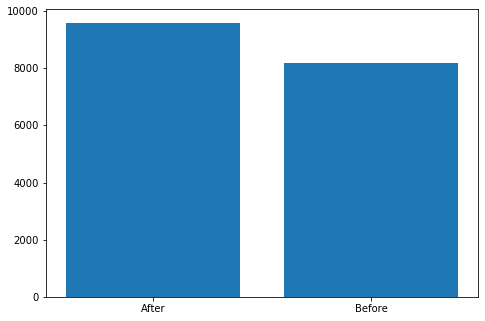

In [24]:
fig = plt.figure()
tweet_type = ['After','Before']
tweet_counts = [pos_count,neg_count]
ax = fig.add_axes([0,0,1,1])
ax.bar(tweet_type,tweet_counts)
plt.show()

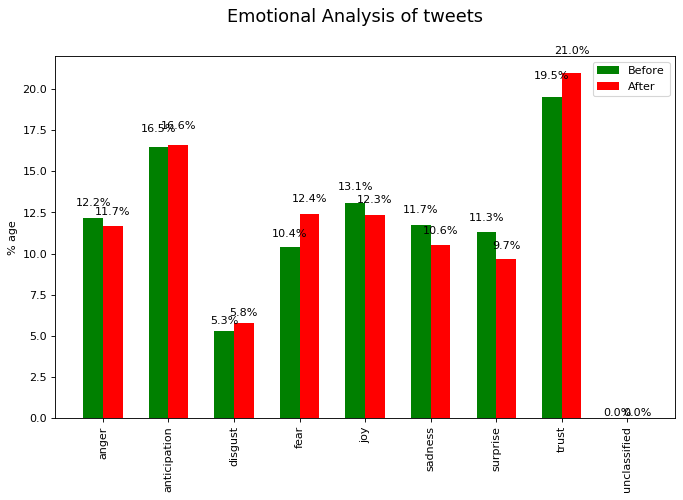

In [73]:

emotions_pos = {'anger': 4004, 'anticipation': 5708, 'disgust': 1987, 'fear': 4256, 'joy': 4235, 'sadness': 3624, 'surprise': 3326, 'trust': 7195, 'unclassified': 0}

total = sum(emotions_pos.values())
for key in emotions_pos:
    percent=(emotions_pos[key]/total)*100
    emotions_pos[key]=percent

emotions_neg = {'anger': 4309, 'anticipation': 5822, 'disgust': 1884, 'fear': 3669, 'joy': 4619, 'sadness': 4153, 'surprise': 3992, 'trust': 6901, 'unclassified': 0}

total = sum(emotions_neg.values())
for key in emotions_neg:
    percent=(emotions_neg[key]/total)*100
    emotions_neg[key]=percent

emotions_colors = {'anger': 'red', 'anticipation': 'purple', 'disgust': 'yellow', 'fear': 'indigo', 'joy': 'green', 'negative': 'black', 'positive': 'pink', 'sadness': 'blue', 'surprise': 'maroon', 'trust': 'orange', 'unclassified': 'cyan'}
#labels = list(emotions_colors.keys())
#handles = [plt.Rectangle((1,1),1,1, color=emotions_colors[label]) for label in labels]
my_cmap = cm.get_cmap('jet')
ind = np.arange(len(emotions_pos))
width=0.3
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
fig.suptitle('Emotional Analysis of tweets', fontsize=16)
ax = fig.add_subplot(111)
pos_bars=ax.bar(ind, list(emotions_neg.values()),width,color='g',align='center')            #before
neg_bars=ax.bar(ind+width, list(emotions_pos.values()),width,color='r', align='center')     #after
ax.set_ylabel('% age')
ax.set_xticklabels(list(emotions_pos.keys()), rotation=90)
ax.set_xticks(ind+width/2)
ax.legend( (pos_bars[0], neg_bars[0]), ('Before', 'After') )

def autolabel(bars):
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x()+bar.get_width()/2., 1.05*h, '%.1f'%float(h)+"%",
                ha='center', va='bottom')

autolabel(pos_bars)
autolabel(neg_bars)

plt.show()

In [7]:
def get_emotions_dict_per_entity(name,emotion):
    with open(name, 'r') as f:
        parsed_file_dict = json.load(f)
    return parsed_file_dict[emotion]

this_map = {'FG':0,'FF':0,'SF':0,'LAB':0,'SOL-PBP':0,'GP':0,'SD':0}

ff_trust = get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_fianna_fáil_after.json",'anticipation') + get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_fianna_fáil_before.json",'anticipation')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_fianna_fáil_before.json",'trust')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_fianna_fáil_after.json",'trust')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_fianna_fáil_before.json",'joy')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_fianna_fáil_after.json",'joy')
ff_positive=get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_fianna_fáil_after.json",'positive') + get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_fianna_fáil_before.json",'positive')

fg_trust = get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_fine_gael_after.json",'anticipation') + get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_fine_gael_before.json",'anticipation')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_fine_gael_before.json",'trust')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_fine_gael_after.json",'trust')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_fine_gael_before.json",'joy')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_fine_gael_after.json",'joy')
fg_positive=get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_fine_gael_after.json",'positive') + get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_fine_gael_before.json",'positive')

gp_trust = get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_green_party_after.json",'anticipation') + get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_green_party_before.json",'anticipation')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_green_party_before.json",'trust')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_green_party_after.json",'trust')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_green_party_before.json",'joy')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_green_party_after.json",'joy')
gp_positive=get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_green_party_after.json",'positive') + get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_green_party_before.json",'positive')

lab_trust = get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_labour_after.json",'anticipation') + get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_labour_before.json",'anticipation')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_labour_before.json",'trust')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_labour_after.json",'trust')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_labour_before.json",'joy')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_labour_after.json",'joy')
lab_positive=get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_labour_after.json",'positive') + get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_labour_before.json",'positive')

sf_trust = get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_sinn_féin_before.json",'anticipation') + get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_sinn_féin_after.json",'anticipation')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_sinn_féin_after.json",'trust')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_sinn_féin_before.json",'trust')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_sinn_féin_after.json",'joy')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_sinn_féin_before.json",'joy')
sf_positive=get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_sinn_féin_before.json",'positive') + get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_sinn_féin_after.json",'positive')

sd_trust = get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_social_democrats_before.json",'anticipation') + get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_social_democrats_after.json",'anticipation')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_social_democrats_after.json",'trust')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_social_democrats_before.json",'trust')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_social_democrats_after.json",'joy')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_social_democrats_before.json",'joy')
sd_positive=get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_social_democrats_after.json",'positive') + get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_social_democrats_before.json",'positive')

sp_trust = get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_solidarity_people_before_profit_after.json",'anticipation') + get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_solidarity_people_before_profit_before.json",'anticipation')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_solidarity_people_before_profit_before.json",'trust')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_solidarity_people_before_profit_after.json",'trust')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_solidarity_people_before_profit_before.json",'joy')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_solidarity_people_before_profit_after.json",'joy')
sp_positive=get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_solidarity_people_before_profit_after.json",'positive') + get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_solidarity_people_before_profit_before.json",'positive')

'''
total_pos = ff_positive+fg_positive+gp_positive+lab_positive+sf_positive+sd_positive+sp_positive
this_map['FG']=(fg_positive/total_pos)*100
this_map['FF']=(ff_positive/total_pos)*100
this_map['SF']=(sf_positive/total_pos)*100
this_map['LAB']=(lab_positive/total_pos)*100
this_map['SOL-PBP']=(sp_positive/total_pos)*100
this_map['GP']=(gp_positive/total_pos)*100
this_map['SD']=(sd_positive/total_pos)*100
'''
total_positive = ff_positive+fg_positive+gp_positive+lab_positive+sf_positive+sd_positive+sp_positive
total_pos = ff_trust+fg_trust+gp_trust+lab_trust+sf_trust+sd_trust+sp_trust
this_map['FG']=(fg_trust/total_pos)*100
this_map['FF']=(ff_trust/total_pos)*100
this_map['SF']=(sf_trust/total_pos)*100
this_map['LAB']=(lab_trust/total_pos)*100
this_map['SOL-PBP']=(sp_trust/total_pos)*100
this_map['GP']=(gp_trust/total_pos)*100
this_map['SD']=(sd_trust/total_pos)*100

print(this_map)

{'FG': 12.53863649618009, 'FF': 12.229544526739371, 'SF': 22.126319472794076, 'LAB': 23.54347699306001, 'SOL-PBP': 3.277541260861958, 'GP': 13.705021286522424, 'SD': 12.579459963842071}


In [80]:
def get_emotions_dict_per_entity(name,emotion):
    with open(name, 'r') as f:
        parsed_file_dict = json.load(f)
    return parsed_file_dict[emotion]

this_map = {'FG':0,'FF':0,'SF':0,'LAB':0,'SOL-PBP':0,'GP':0,'SD':0}

ff_trust = get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_fianna_fáil_before.json",'trust')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_fianna_fáil_after.json",'trust')
ff_positive=get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_fianna_fáil_after.json",'positive') + get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_fianna_fáil_before.json",'positive')

fg_trust = get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_fine_gael_before.json",'trust')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_fine_gael_after.json",'trust')
fg_positive=get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_fine_gael_after.json",'positive') + get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_fine_gael_before.json",'positive')

gp_trust = get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_green_party_before.json",'trust')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_green_party_after.json",'trust')
gp_positive=get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_green_party_after.json",'positive') + get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_green_party_before.json",'positive')

lab_trust = get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_labour_before.json",'trust')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_labour_after.json",'trust')
lab_positive=get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_labour_after.json",'positive') + get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_labour_before.json",'positive')

sf_trust =  get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_sinn_féin_after.json",'trust')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_sinn_féin_before.json",'trust')
sf_positive=get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_sinn_féin_before.json",'positive') + get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_sinn_féin_after.json",'positive')

sd_trust =get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_social_democrats_after.json",'trust')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_social_democrats_before.json",'trust')
sd_positive=get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_social_democrats_after.json",'positive') + get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_social_democrats_before.json",'positive')

sp_trust = get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_solidarity_people_before_profit_before.json",'trust')+ get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_solidarity_people_before_profit_after.json",'trust')
sp_positive=get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_solidarity_people_before_profit_after.json",'positive') + get_emotions_dict_per_entity("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/jsons/emotions_solidarity_people_before_profit_before.json",'positive')

'''
total_pos = ff_positive+fg_positive+gp_positive+lab_positive+sf_positive+sd_positive+sp_positive
this_map['FG']=(fg_positive/total_pos)*100
this_map['FF']=(ff_positive/total_pos)*100
this_map['SF']=(sf_positive/total_pos)*100
this_map['LAB']=(lab_positive/total_pos)*100
this_map['SOL-PBP']=(sp_positive/total_pos)*100
this_map['GP']=(gp_positive/total_pos)*100
this_map['SD']=(sd_positive/total_pos)*100
'''
total_positive = ff_positive+fg_positive+gp_positive+lab_positive+sf_positive+sd_positive+sp_positive
total_pos = ff_trust+fg_trust+gp_trust+lab_trust+sf_trust+sd_trust+sp_trust
this_map['FG']=(fg_trust/total_pos)*100
this_map['FF']=(ff_trust/total_pos)*100
this_map['SF']=(sf_trust/total_pos)*100
this_map['LAB']=(lab_trust/total_pos)*100
this_map['SOL-PBP']=(sp_trust/total_pos)*100
this_map['GP']=(gp_trust/total_pos)*100
this_map['SD']=(sd_trust/total_pos)*100

print(this_map)

{'FG': 13.619616313047898, 'FF': 14.00076229195782, 'SF': 13.822894168466524, 'LAB': 16.249523567526364, 'SOL-PBP': 12.831914623300724, 'GP': 15.436412145851861, 'SD': 14.038876889848812}


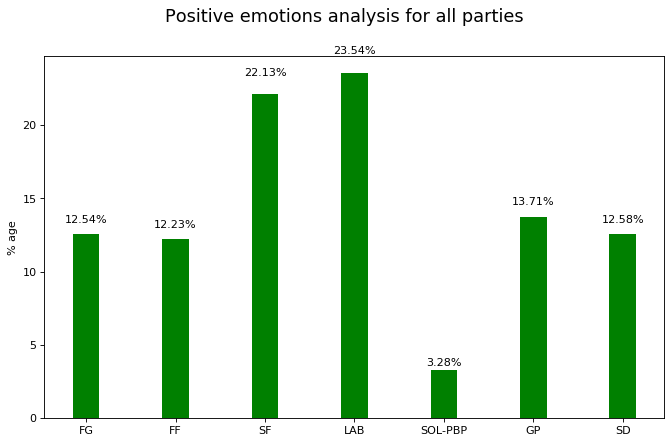

In [8]:
emotions_colors = {'anger': 'red', 'anticipation': 'purple', 'disgust': 'yellow', 'fear': 'indigo', 'joy': 'green', 'negative': 'black', 'positive': 'pink', 'sadness': 'blue', 'surprise': 'maroon', 'trust': 'orange', 'unclassified': 'cyan'}
#labels = list(emotions_colors.keys())
#handles = [plt.Rectangle((1,1),1,1, color=emotions_colors[label]) for label in labels]
my_cmap = cm.get_cmap('jet')
ind = np.arange(len(this_map))
width=0.3
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
fig.suptitle('Positive emotions analysis for all parties', fontsize=16)
ax = fig.add_subplot(111)
pos_bars=ax.bar(ind, list(this_map.values()),width,color='g',align='center')
ax.set_ylabel('% age')
ax.set_xticklabels(list(this_map.keys()))
ax.set_xticks(ind)
#ax.legend( (pos_bars[0], neg_bars[0]), ('After', 'Before') )

def autolabel(bars):
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x()+bar.get_width()/2., 1.05*h, '%.2f'%float(h)+"%",
                ha='center', va='bottom')

autolabel(pos_bars)
root_path=("C://Users//SIDDHARTHA//Trinity//TextAnalysis//TextAnalysis//Sentimentalysis")
plt.savefig(os.path.join(root_path,'plots',"positive_emo_parties.png"), bbox_inches="tight")
plt.show()